In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import spearmanr
from datetime import datetime
import statistics

current_date = datetime.now()
formatted_date = current_date.strftime("%Y.%m.%d")

root = '/Users/grantongo/Desktop/nature methods/figures'

In [2]:
def remove_spiked_cytokines(df):
    
    df.cytokine = df['cytokine'].replace('/', ' ', regex=True)
    df = df[(df.donor != 7) & (df.donor != 8)]    

    # known cross reactivities due to shared homology 
    cross_reactives = {"CXCL12 (alpha)" : ["CXCL12 (beta)"],
                       "CXCL12 (beta)" : ["CXCL12 (alpha)"],
                       "IL-12 p40" : ["IL-12 p70", "IL-23"], 
                       "IL-12 p35" : ["IL-12 p70"]}

    # cytokine spiked signal replaced with signal from matched control for donor, stimulus, and stimulus concentration
    for donor in df.donor.unique():
        for stim in df.stimulus.unique():
            for stimconc in set(df[(df.stimulus==stim) & (df.donor==donor)]['stimulus_concentration']):
                for sensor in sensors:

                    df_control = df[(df.stimulus==stim) & 
                                    (df.stimulus_concentration==stimconc) & 
                                    (df.cytokine=='control') & 
                                    (df.donor==donor)]
                    control_signal = np.nanmedian(df_control[sensor].astype(float))

                    # when a sensor detects it's spiked in cytokine, replace with the matched control signal
                    if sensor in set(df.cytokine):
                        
                        df.loc[(df.stimulus==stim) & 
                               (df.stimulus_concentration==stimconc) & 
                               (df.cytokine==sensor) & 
                               (df.donor==donor),sensor] = control_signal

                    # when the sensor has known cross reactivities, replace with the matched control as well
                    if sensor in cross_reactives:
                        for sensor_cr in cross_reactives[sensor]:
                            df.loc[(df.stimulus==stim) & 
                                   (df.stimulus_concentration==stimconc) & 
                                   (df.cytokine==sensor_cr) & 
                                   (df.donor==donor),sensor] = control_signal

    return df
def drop_outliers(df): 
    
    h_in, w_in = df.shape

    # next remove rows of outliers (where all nans)
    df = df.dropna(axis=0, subset=sensors, how='all')

    nans = df.isna().sum()
    mode = statistics.mode(nans[nans!=0])

    init_columns = df.columns
    
    # remove sensors with high number of nan
    df = df.loc[:,df.isna().sum() < mode+10]

    print(f'columns dropped: {[x for x in init_columns if x not in df.columns]}')
    
    # drop wells with outliers
    df = df.dropna(axis=0, how='any')

    h_out, w_out = df.shape
    
    print(f'columns dropped: {w_in-w_out} \noutliers dropped: {h_in-h_out}\n')
    
    return df

sensors = pd.read_csv(f'{root}/data/pbmc/pbmc_sensors.csv', header=None)[0]

df_SNR = pd.read_csv(f'{root}/data/pbmc/pbmc_snr.csv')
df_SNR = remove_spiked_cytokines(df_SNR)
df_SNR = drop_outliers(df_SNR)

df_PGML = pd.read_csv(f'{root}/data/pbmc/pbmc_pgml_imputed.csv')
df_PGML = remove_spiked_cytokines(df_PGML)
df_PGML = drop_outliers(df_PGML)

sensors = [x for x in df_SNR.columns if x in sensors.tolist()]
print(f'total sensors: {len(sensors)}')

columns dropped: []
columns dropped: 0 
outliers dropped: 16

columns dropped: []
columns dropped: 0 
outliers dropped: 16

total sensors: 191


In [3]:
def volcano(df_SNR, df_PGML, pval_thresh, fc_thresh): 
    volcano_significant = pd.DataFrame()
    volcano_all = pd.DataFrame()
    for stim in df_SNR.stimulus.unique():
        print(f'stimulus: {stim}')
        for cyto in df_SNR.cytokine.unique():
            #print(f'cytokine: {cyto}')
            for stimconc in df_SNR.stimulus_concentration[(df_SNR.stimulus == stim) & (df_SNR.cytokine == cyto)].unique().tolist():
                #print(f'cytokine concentration: {stimconc}')
                testgroup_snr = df_SNR[(df_SNR.stimulus == stim) & 
                                       (df_SNR.cytokine == cyto) & 
                                       (df_SNR.stimulus_concentration == stimconc)]
                controlgroup_snr = df_SNR[(df_SNR.stimulus == stim) & 
                                          (df_SNR.cytokine == 'control') & 
                                          (df_SNR.stimulus_concentration == stimconc)]
                testgroup_pgml = df_PGML[(df_PGML.stimulus == stim) & 
                                         (df_PGML.cytokine == cyto) & 
                                         (df_PGML.stimulus_concentration == stimconc)]
                controlgroup_pgml = df_PGML[(df_PGML.stimulus == stim) & 
                                            (df_PGML.cytokine == 'control') & 
                                            (df_PGML.stimulus_concentration == stimconc)]
                for sensor in sensors:
                    volcano = pd.DataFrame()
                    if sensor in df_SNR.columns:
                        # print(sensor)
                        # calculate pvalue using SNR
                        fval, pval = stats.f_oneway(testgroup_snr[sensor], controlgroup_snr[sensor])
                        qval = -1*np.log10(pval)
                        # calculate foldchange using pg/ml
                        fc = statistics.median(testgroup_pgml[sensor])/statistics.median(controlgroup_pgml[sensor]) 
                        log2fc = np.log2(abs(fc))

                        volcano = pd.DataFrame(data = {'cytokine':[cyto],
                                                       'stimulus':[stim],
                                                       'stimulus_concentration':[stimconc],
                                                       'sensor':[sensor], 
                                                       'pvalue':[pval], 
                                                       'qvalue':[qval], 
                                                       'foldchange':[fc],
                                                       'log2fc':[log2fc]})
                        volcano = volcano.replace(np.inf, np.nan)
                        volcano_significant = pd.concat([volcano_significant,
                                                         volcano[(volcano.log2fc<-np.log2(abs(fc_thresh))) & 
                                                                 (volcano.qvalue>-np.log10(pval_thresh))],
                                                         volcano[(volcano.log2fc>np.log2(abs(fc_thresh))) & 
                                                                 (volcano.qvalue>-np.log10(pval_thresh))]
                                                        ], axis=0)
                        
                        volcano_all = pd.concat([volcano_all,volcano], axis=0)
    
        print(f'volcano_significant: {len(volcano_significant)}')
        print(f'volcano_all: {len(volcano_all)}')
        
    # pairs of cytokine perturbations with significant target expression
    volcano_significant['pairs'] = volcano_significant['cytokine'].map(str) + ' | ' + volcano_significant['sensor'].map(str)
    
    vol_lps = volcano_significant[volcano_significant.stimulus=='LPS']
    vol_pmai = volcano_significant[volcano_significant.stimulus=='PMAi']
    vol_cona = volcano_significant[volcano_significant.stimulus=='ConA']
    vol_polyic = volcano_significant[volcano_significant.stimulus=='PolyIC']
    vol_control = volcano_significant[volcano_significant.stimulus=='control']

    print(f'''\nfoldchange > {fc_thresh}, pvalue <{pval_thresh}
    
    Total
    \ttotal number of hits: {len(volcano_significant)}
    \ttotal number of unique cytokine-sensor pairs: {len(volcano_significant.pairs.unique())}
    \ttotal number of unique cytokines: {len(set(volcano_significant.cytokine))}
    \ttotal number of unique sensors: {len(set(volcano_significant.sensor))}
    
    ConA
    \ttotal number of hits for ConA: {len(vol_cona)}
    \tunique pairs for ConA: {len(vol_cona['pairs'].unique())}
    
    LPS
    \ttotal number of hits for LPS: {len(vol_lps)}
    \tunique pairs for LPS: {len(vol_lps['pairs'].unique())}
    
    PMAi
    \ttotal number of hits for PMAi: {len(vol_pmai)}
    \tunique pairs for PMAi: {len(vol_pmai['pairs'].unique())}
    
    ConA
    \ttotal number of hits for PolyIC: {len(vol_polyic)}
    \tunique pairs for PolyIC: {len(vol_polyic['pairs'].unique())}
    
    Control
    \ttotal number of hits for the no_stimulus_control: {len(vol_control)}
    \tunique pairs for the no_stimulus_control: {len(vol_control['pairs'].unique())}''')
        
    return volcano_significant, volcano_all

volcano_significant, volcano_all = volcano(df_SNR, df_PGML, pval_thresh=0.05, fc_thresh=1.5)

volcano_significant.to_csv(f'{root}/data/pbmc/pbmc_significant_responses_{formatted_date}.csv')
volcano_all.to_csv(f'{root}/data/pbmc/pbmc_all_responses_{formatted_date}.csv')

stimulus: ConA
volcano_significant: 457
volcano_all: 46413
stimulus: control
volcano_significant: 682
volcano_all: 61884
stimulus: LPS
volcano_significant: 985
volcano_all: 108297
stimulus: PMAi
volcano_significant: 1086
volcano_all: 139239
stimulus: PolyIC
volcano_significant: 1634
volcano_all: 185652
foldchange > 1.5, pvalue <0.05
    
    Total
    	total number of hits: 1634
    	total number of unique cytokine-sensor pairs: 449
    	total number of unique cytokines: 69
    	total number of unique sensors: 49
    
    ConA
    	total number of hits for ConA: 457
    	unique pairs for ConA: 271
    
    LPS
    	total number of hits for LPS: 303
    	unique pairs for LPS: 119
    
    PMAi
    	total number of hits for PMAi: 101
    	unique pairs for PMAi: 75
    
    ConA
    	total number of hits for PolyIC: 548
    	unique pairs for PolyIC: 284
    
    Control
    	total number of hits for the no_stimulus_control: 225
    	unique pairs for the no_stimulus_control: 225


	CytoSig
    		total detected by CytoSig: 137
    		exclusively detected by CytoSig: 91
    	nELISA
    		total detected by nELISA: 447
    		exclusively detected by nELISA: 401
    	Both
    		detected by both: 46
    		positively correlated (both + or - foldchange): 40
    		negatively correlated (+ and - foldchanges): 6
    		correlation: 87.0%


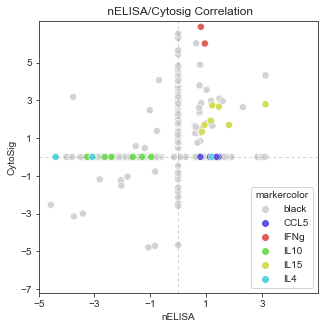

In [12]:
# cytosig correlation

volcano_significant = pd.read_csv(f'{root}/data/pbmc/pbmc_significant_responses_2025.01.16.csv')

def cytosig_correlation(volcano_stats=volcano_significant):
    
    # dictionary for cytokine to gene id
    uniprot_gene = pd.read_csv(f'{root}/data/cytosig/uniprot_to_gene.csv', header=None)
    dict_gene = dict(zip(uniprot_gene[0],uniprot_gene[2]))

    # import cytosig data
    import os
    from os import listdir
    
    df_cytosig = pd.DataFrame()
    for file in os.listdir(f'{root}/data/cytosig'):
        if not file in ['.DS_Store','uniprot_to_gene.csv']:
            data = pd.read_csv(f'{root}/data/cytosig/{file}')
            data['Cytokine'] = file.removesuffix('.csv')
            data['Protein_name'] = file.removesuffix('.csv')
            df_cytosig = pd.concat([df_cytosig,data])
    df_cytosig = df_cytosig.replace({'Cytokine': dict_gene})
    df_cytosig['Origin'] = 'CytoSig'
    
    # filter by high quality
    df_cytosig = df_cytosig[(df_cytosig['High Quality']==True)] 

    # filter for gene targets on nELISA panel
    df_cytosig = df_cytosig[df_cytosig.Gene.isin(uniprot_gene[2])]

    # filter for PBMCs
    cytosig_celltypes = ['Peripheral Blood Mononuclear',
                         'Pbmc',
                         'Pbmc From Patients With Multiple Sclerosis',
                         'Pbmc Lps Primed',
                         'Pbmc+Mec=10:1',
                         'Pbmc+Mec=1:1',
                         'Pbmc+Rv16',
                         'Pbmc-Derived T Lymphocyte',
                         'Pbmc.Cd14+',
                         'Pbmc.Complete_Responder',
                         'Pbmc.Partial_Responder',
                         'Peripheral Blood Mononuclear']
    df_cytosig = df_cytosig[df_cytosig.Model.isin(cytosig_celltypes)]

    # nELISA dataframe with significant fold changes
    df_nelisa = pd.DataFrame({'Value' : volcano_stats['log2fc'],
                              'Cytokine' : volcano_stats['cytokine'].replace(dict_gene),
                              'Protein_name' : volcano_stats['cytokine'],
                              'Dose' : volcano_stats['stimulus_concentration'],
                              'Detail' : volcano_stats['stimulus'],
                              'Gene' : volcano_stats['sensor'].replace(dict_gene),
                              'Model' : 'PBMC',
                              'Origin' : 'nELISA'
                             })

    # calculate median value of fold change
    df_nelisa_median = pd.DataFrame(df_nelisa.groupby(['Cytokine','Gene'], as_index=False)['Value'].median())
    df_cytosig_median = pd.DataFrame(df_cytosig.groupby(['Cytokine','Gene'], as_index=False)['Value'].median())

    # merge nELISA and cytosig datasets for plotting 
    df_plotly = df_nelisa_median.merge(df_cytosig_median, how = 'outer', on = ['Cytokine', 'Gene'])
    df_plotly['Identifier'] = 'Perturbagen ' + df_plotly['Cytokine'].map(str) + ' | ' + df_plotly['Gene'].map(str) + ' expression' 
    df_plotly.set_index('Identifier', inplace=True)
    df_plotly.columns = ['Cytokine', 'Gene', 'nELISA', 'CytoSig']
    
    # calculate the cytosig / nELISA overlap
    df_plotly_both = df_plotly.dropna()
    total_count = len(df_plotly_both)
    pos_correlations = len(df_plotly_both[(df_plotly_both.nELISA>0) & 
                                          (df_plotly_both.CytoSig>0)]) + len(df_plotly_both[(df_plotly_both.nELISA<0) & 
                                                                                            (df_plotly_both.CytoSig<0)])
    neg_correlations = len(df_plotly_both[(df_plotly_both.nELISA>0) & 
                                          (df_plotly_both.CytoSig<0)]) + len(df_plotly_both[(df_plotly_both.nELISA<0) & 
                                                                                            (df_plotly_both.CytoSig>0)])
    percent_correlation = np.round(pos_correlations/total_count*100)

    print(f"""\tCytoSig
    \t\ttotal detected by CytoSig: {len(df_plotly[~df_plotly.CytoSig.isna()])}
    \t\texclusively detected by CytoSig: {len(df_plotly[df_plotly.nELISA.isna()])}
    \tnELISA
    \t\ttotal detected by nELISA: {len(df_plotly[~df_plotly.nELISA.isna()])}
    \t\texclusively detected by nELISA: {len(df_plotly[df_plotly.CytoSig.isna()])}
    \tBoth
    \t\tdetected by both: {len(df_plotly.dropna())}
    \t\tpositively correlated (both + or - foldchange): {pos_correlations}
    \t\tnegatively correlated (+ and - foldchanges): {neg_correlations}
    \t\tcorrelation: {percent_correlation}%""")
    
    df_plotly['markercolor'] = 'black'
    df_plotly['markerstyle'] = 'circle'
    df_plotly['markersize'] = 100
    
    # IFNg induces CXCL9, CXCL10
    df_plotly.loc[(df_plotly.Cytokine=='IFNG') & (df_plotly.Gene.isin(['CXCL9','CXCL10'])),'markerstyle'] = 'diamond'
    df_plotly.loc[(df_plotly.Cytokine=='IFNG') & (df_plotly.Gene.isin(['CXCL9','CXCL10'])),'markersize'] = 300
    df_plotly.loc[(df_plotly.Cytokine=='IFNG') & (df_plotly.Gene.isin(['CXCL9','CXCL10'])),'markercolor'] = 'IFNg'
    
    # IL-15 induces IFNg, TNFa, CXCL9, CXCL10, CCL5, IL-17F, IL-22, IL-1a, and IL-1b
    df_plotly.loc[(df_plotly.Cytokine=='IL15') & (df_plotly.Gene.isin(['IFNG','TNFA','CXCL9','CXCL10','CCL5','IL17F','IL22','IL1B'])),'markerstyle'] = 'star'
    df_plotly.loc[(df_plotly.Cytokine=='IL15') & (df_plotly.Gene.isin(['IFNG','TNFA','CXCL9','CXCL10','CCL5','IL17F','IL22','IL1B'])),'markersize'] = 5000    
    df_plotly.loc[(df_plotly.Cytokine=='IL15') & (df_plotly.Gene.isin(['IFNG','TNFA','CXCL9','CXCL10','CCL5','IL17F','IL22','IL1B'])),'markercolor'] = 'IL15' 
    
    # IL-10 inhibits IFNg, TNFa, IL-1b, IL-12 p40, CCL1, CCL3, CCL4, CCL5, CCL19, CXCL5, G-CSF, MMP-1
    df_plotly.loc[(df_plotly.Cytokine=='IL10') & (df_plotly.Gene.isin(['IFNG','TNFA','IL1B','IL12B','CCL1','CCL3','CCL4','CCL5','CCL19','CXCL5','CSF3','MMP1'])),'markerstyle'] = 'v'
    df_plotly.loc[(df_plotly.Cytokine=='IL10') & (df_plotly.Gene.isin(['IFNG','TNFA','IL1B','IL12B','CCL1','CCL3','CCL4','CCL5','CCL19','CXCL5','CSF3','MMP1'])),'markersize'] = 5000  
    df_plotly.loc[(df_plotly.Cytokine=='IL10') & (df_plotly.Gene.isin(['IFNG','TNFA','IL1B','IL12B','CCL1','CCL3','CCL4','CCL5','CCL19','CXCL5','CSF3','MMP1'])),'markercolor'] = 'IL10'   
    
    # IL-4 induces CCL22, CCL24, IL-4 inhibits IFNg, TNFa, IL-1b
    df_plotly.loc[(df_plotly.Cytokine=='IL4') & (df_plotly.Gene.isin(['CCL22','CCL23','IFNG','TNFA','IL1B'])),'markerstyle'] = 'x'
    df_plotly.loc[(df_plotly.Cytokine=='IL4') & (df_plotly.Gene.isin(['CCL22','CCL23','IFNG','TNFA','IL1B'])),'markersize'] = 5000
    df_plotly.loc[(df_plotly.Cytokine=='IL4') & (df_plotly.Gene.isin(['CCL22','CCL23','IFNG','TNFA','IL1B'])),'markercolor'] = 'IL4'
    
    # - IL-2 induces CCL5, IL-7 induces CCL5, IL-18 induces CCL5, IFNa2/b induces CCL5
    df_plotly.loc[(df_plotly.Cytokine.isin(['IL2','IL7','IL18','IFNA2'])) & (df_plotly.Gene.isin(['CCL5'])),'markerstyle'] = 'square'
    df_plotly.loc[(df_plotly.Cytokine.isin(['IL2','IL7','IL18','IFNA2'])) & (df_plotly.Gene.isin(['CCL5'])),'markersize'] = 5000
    df_plotly.loc[(df_plotly.Cytokine.isin(['IL2','IL7','IL18','IFNA2'])) & (df_plotly.Gene.isin(['CCL5'])),'markercolor'] = 'CCL5'
    
    # Regression plot : non-filtered data 
    total_count = len(df_plotly.dropna())
    pos_correlations = len(df_plotly[(df_plotly.nELISA>0) & (df_plotly.CytoSig>0)]) + len(df_plotly[(df_plotly.nELISA<0) & (df_plotly.CytoSig<0)])
    neg_correlations = len(df_plotly[(df_plotly.nELISA>0) & (df_plotly.CytoSig<0)]) + len(df_plotly[(df_plotly.nELISA<0) & (df_plotly.CytoSig>0)])
    percent_correlation = pos_correlations/total_count*100

    # figure
    import matplotlib.lines as mlines
    minx, maxx, miny, maxy = -5, 5, -7.2, 7.2
    
    sbn.set_style("ticks")
    fig, ax = plt.subplots(1,1, figsize=(5,5), gridspec_kw={'wspace':0.15})
    ax = sbn.scatterplot(data=df_plotly[df_plotly.markercolor=='black'].replace(np. nan,0),
                              x='nELISA',
                              y='CytoSig',
                              hue='markercolor', 
                              s = 50,
                              palette=dict(black='lightgrey',IFNg='#db5f57ff',IL15='#d3db57ff',IL10='#75db57ff',IL4='#57d3dbff',CCL5='#5f57dbff')
                              )
    ax = sbn.scatterplot(data=df_plotly[df_plotly.markercolor!='black'].replace(np. nan,0),
                              x='nELISA',
                              y='CytoSig',
                              hue='markercolor', 
                              s = 50,
                              palette=dict(black='lightgrey',IFNg='#db5f57ff',IL15='#d3db57ff',IL10='#75db57ff',IL4='#57d3dbff',CCL5='#5f57dbff')
                              )
    ax.add_line(mlines.Line2D([minx, maxx], [0, 0], color='gray', alpha=0.7, dash_capstyle='round',dashes=[6],linewidth=0.5))
    ax.add_line(mlines.Line2D([0, 0], [miny,maxy], color='gray', alpha=0.7, dash_capstyle='round',dashes=[6],linewidth=0.5))

    ax.set_title(' nELISA/Cytosig Correlation')
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    ax.xaxis.set_ticks(np.arange(minx, maxx, 2))
    ax.yaxis.set_ticks(np.arange(-7, 7, 2))

    fig.savefig(f'{root}/figure 4/svg_figure.4.c_cytosig_{formatted_date}.svg')
    
    return df_plotly

df_plotly = cytosig_correlation(volcano_stats=volcano_significant)